# Shallow Water Finite Volume Models

It is recommended to run all these notebooks at least once, in order to generate all required modules.


## Schemes considering horizontal bottom

### Dambreak analytical solution

[dambreak.ipynb](dambreak.ipynb)

The first analytical solution we tried for validating our schemes.

It generates the module **dambreak.py**, which contains routines to obtain this solution given some parameters.

### First order scheme

[nswe_order1.ipynb](nswe_order1.ipynb)

An implementation of a shock capturing first order scheme. It also contains a discussion of instabilities observed in numerical experiments for the dambreak solution with dry bottom and open or closed boundary conditions.

It requires the module **dambreak.py**.

It generates the module **nswe1.py**, which contains the implementation of this solver.

### Second order scheme

[nswe_muscl_2order.ipynb](nswe_muscl_2order.ipynb)

It uses the same FV formulation but with second order MUSCL reconstruction of variables. Here is also a discussion about the MUSCL slope limiters, and some quick numerical tests.

It requieres the module **nswe1.py** (for comparison).

It generates the module **muscl2.py**.

### Fourth order scheme

[nswe_muscl_4order.ipynb](swe_muscl_4order.ipynb)

[nswe_muscl_4order_reconstruct_u.ipynb](nswe_muscl_4order_reconstruct_u.ipynb)

Same FV formulation with a fourth order MUSCL reconstruction. I am not very sure of what all the differences between these two are, but at least the second one uses h and u as main variables (whereas the other uses h and hu). This is an improvement made to avoid many "divide by h" operations. 

It also tries to compare with the 4th order well balanced scheme and for that reason it is not using limiters, so that's why the dambreak case turns very oscillatory near the discontinuity and then unstable.

To execute cells starting from [39] you will need the **nswe_wbmuscl4.py** module.

It does not generate any module.

## Schemes considering non-horizontal bottom (Well-balanced schemes)

All of these schemes are 4th order in time, using a RK scheme.

### Second order WB scheme

[nswe_wbmuscl2.ipynb](nswe_wbmuscl2.ipynb)

[nswe_wbmuscl2_handu.ipynb](nswe_wbmuscl2_handu.ipynb)

Implementation of the well balanced scheme that uses the hydrostatic reconstruction to preserve steady states at rest. There is also a comparison between Euler and RK4 schemes. 

The second one uses h and u as main variables, whereas the other uses h and hu. This is not a difference in the scheme, but only in the computer implementation.

It also contains a quick DB case that illustrates that wall boundaries defined as topography work well, opposite to what happened with the horizontal bottom case. The second notebook also shows other toy case to see the interaction with a step and variable slope.

It generates the module **nswe_wbmuscl2.py**.

** Please run the second notebook to generate this module, since it is more stable than the first one**

### Validation tests for the WB2 scheme

[nswe_wbmuscl2_handu_tests.ipynb](nswe_wbmuscl2_handu_tests.ipynb)

[nswe_wbmuscl2_tests.ipynb](nswe_wbmuscl2_handu_tests.ipynb) **not working**

Tests considered:
* Lake at rest
* Incident sinusoidal wave (boundary condition)
* Incident sinusoidal wave over a beach with slope
* Subcritical flow over a bump (analytical solution at steady state)

It requires the **nswe_wbmuscl2.py** module.

Tests look successful.


### Fourth order scheme

[nswe_wbmuscl4.ipynb](nswe_wbmuscl4.ipynb)

It implements the same fourth order scheme as with horizontal bottom but without using limiters, and using the 2nd order hydrostatic reconstruction and source balancing strategy. Also shows two validation cases at the end which look successful.

It generates the **nswe_wbmuscl4.py** module.

### Comparison of WB schemes

[nswe_wbcomparison.ipynb](nswe_wbcomparison.ipynb)

Test case for comparing the WB2 and WB4 schemes. Here the  "subcritical flow over a bump" is used where the evolution of the global numerical error is compared. It is also confirmed that the 4th order scheme has a smaller error compared to the 2nd order scheme.

It requires the **nswe_wbmuscl2.py** and **nswe_wbmuscl4.py** modules.


# Adapting the final code for the Serre splitting scheme

[nswe_muscl4_forSerre.ipynb][nswe_muscl4_forSerre.ipynb]

Here you find an example of how to call the function from the splitting scheme routines.

# Dambreak analytical solution to the SWEa

In [1]:
%%writefile dambreak.py
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from matplotlib import animation
from JSAnimation import IPython_display
g = 9.81

Writing dambreak.py


In [2]:
%%writefile dambreak.py -a

def cmEquation(x,hl,hr,g) :
    return -8.*g*hr*x*x*np.power(np.sqrt(g*hl)-x,2) + np.power(x*x-g*hr,2)*(x*x+g*hr)

Appending to dambreak.py


In [3]:
%%writefile dambreak.py -a

def SWAnalyticalSolutionWet(x,t,x0,hl,hr,g) :
    c = np.sqrt(g*hl)
    cm = fsolve(cmEquation,4/3*hl,args=(hl,hr,g))[0]
    xa = x0 - t*c
    xb = x0 + t*(2.*c - 3.*cm)
    xc = x0 + t*(2*cm*cm*(c-cm)/(cm*cm-g*hr))

    h = np.where(x<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),np.where(x<xc,cm*cm/g,hr)))
    u = np.where(x<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),np.where(x<xc, 2*(c-cm), 0)))
    
    return h,u

Appending to dambreak.py


In [4]:
%%writefile dambreak.py -a

def SWAnalyticalSolutionDry(x,t,x0,hl,g) :
    c = np.sqrt(g*hl)
    xa = x0 - t*c
    xb = x0 + 2.*t*c
    g = 9.81

    h = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),0))
    u = np.where(x[:]<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),0))

    
    return h,u

Appending to dambreak.py


In [5]:
%%writefile dambreak.py -a

def plot_dry(hl):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10,10), ylim=(-0.1, 10.1))    
    x = np.linspace(-10,10,100)    
    line, = ax.plot([],[])
    def animate(i):
        h1,u1 = SWAnalyticalSolutionDry(x,i/10.0,0.0,hl,9.81)
        line.set_data(x,h1)
        return line,

    anim = animation.FuncAnimation(fig, animate, frames=20, interval=45)
    return anim

Appending to dambreak.py


In [6]:
%%writefile dambreak.py -a

def plot_wet(hl,hr):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10,10), ylim=(-0.1, 10.1))
    line, = ax.plot([],[])
    x = np.linspace(-10,10,100)
    g = 9.81
    def animate(i):    
        t = i/10.
        x0 = 0.0    
        h1,u1 = SWAnalyticalSolutionWet(x,t,x0,hl,hr,g)
        line.set_data(x,h1)
        return line,

    return animation.FuncAnimation(fig, animate, frames=20, interval=45)

Appending to dambreak.py


dambreak.py:26: RuntimeWarning: divide by zero encountered in divide
  h = np.where(x[:]<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),0))
dambreak.py:27: RuntimeWarning: divide by zero encountered in divide
  u = np.where(x[:]<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),0))



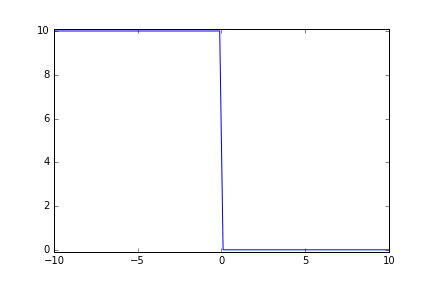
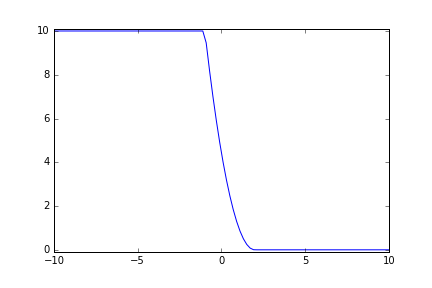
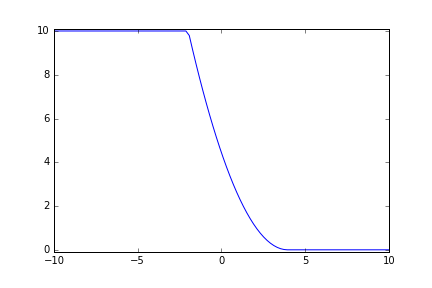
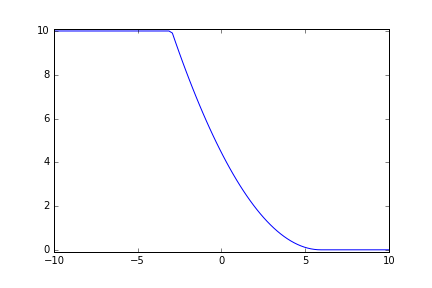
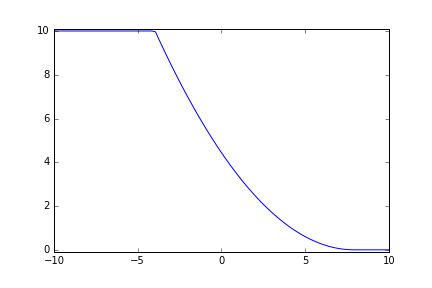
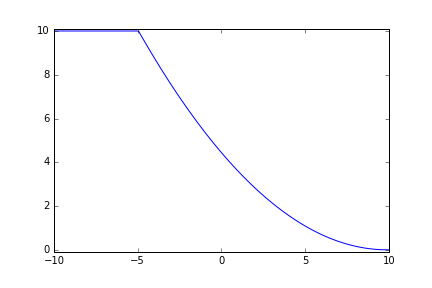
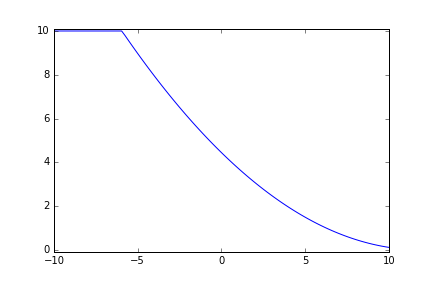
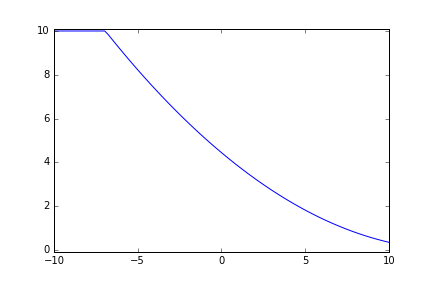
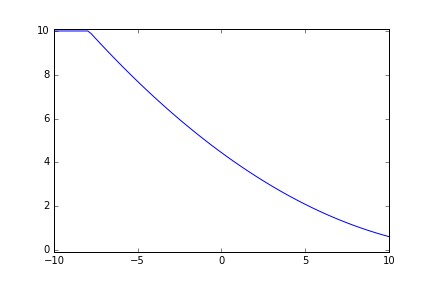
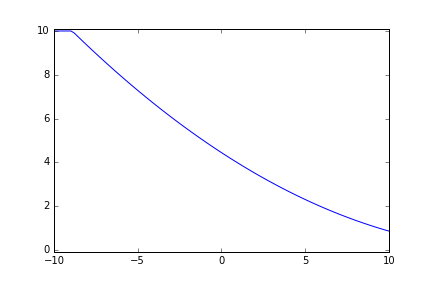
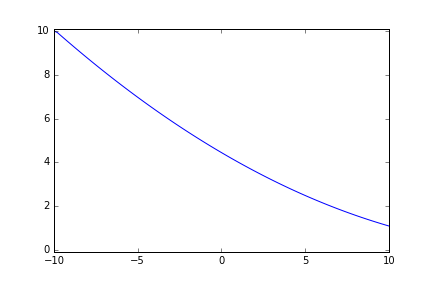
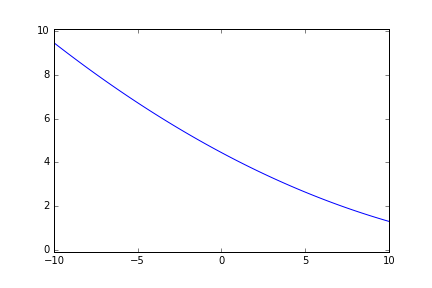
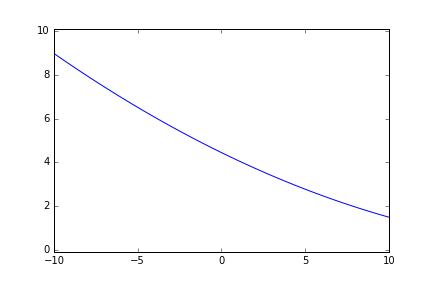
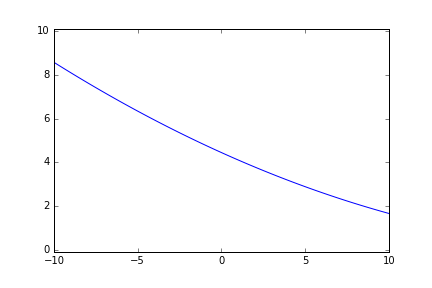
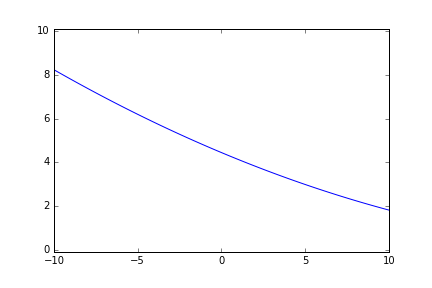
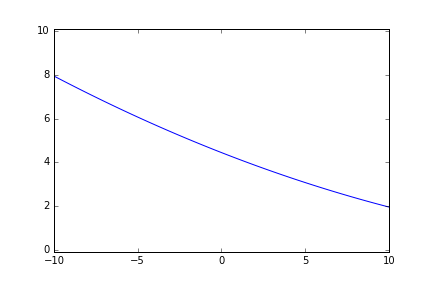
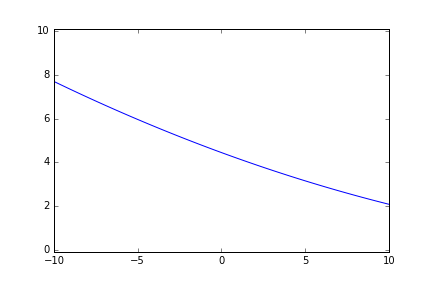
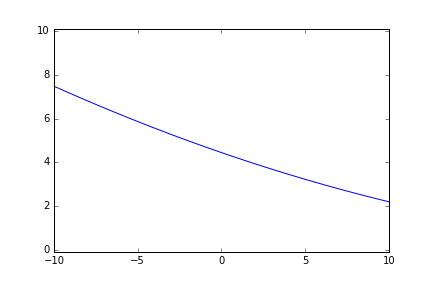
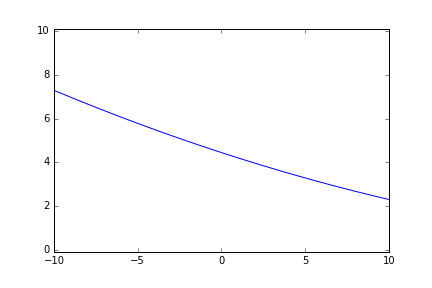
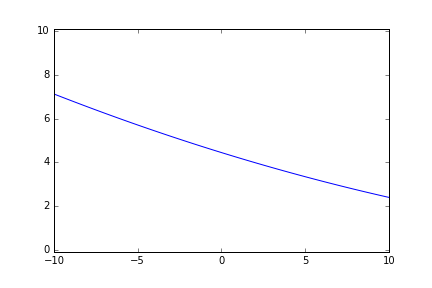

In [7]:
import dambreak
%matplotlib inline
dambreak.plot_dry(10.0)

dambreak.py:16: RuntimeWarning: divide by zero encountered in divide
  h = np.where(x<=xa, hl, np.where(x<xb,4./(9.*g)*np.power(c-(x[:]-x0)/(2.*t),2),np.where(x<xc,cm*cm/g,hr)))
dambreak.py:17: RuntimeWarning: divide by zero encountered in divide
  u = np.where(x<=xa, 0,np.where(x<xb, 2./3.*(c+(x[:]-x0)/t),np.where(x<xc, 2*(c-cm), 0)))



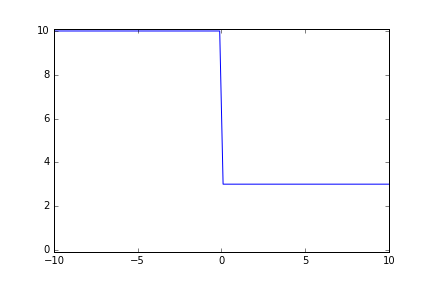
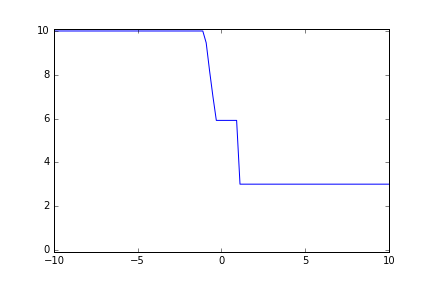
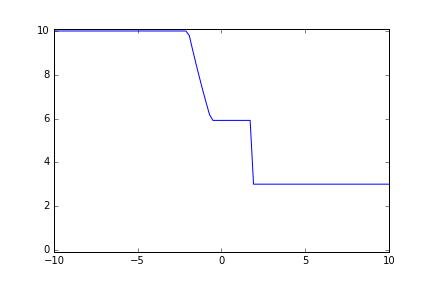
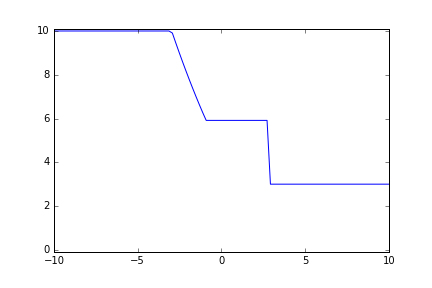
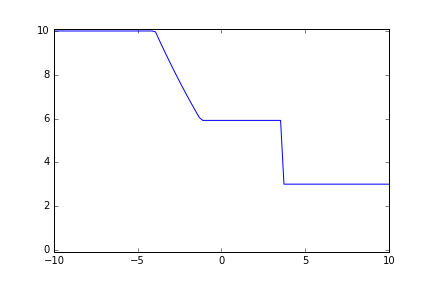
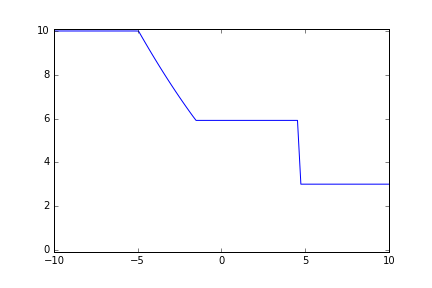
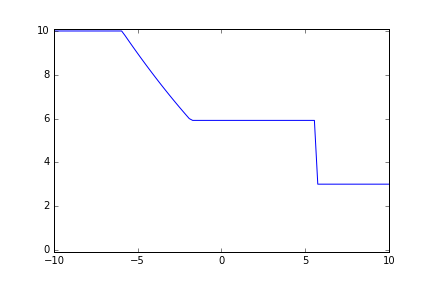
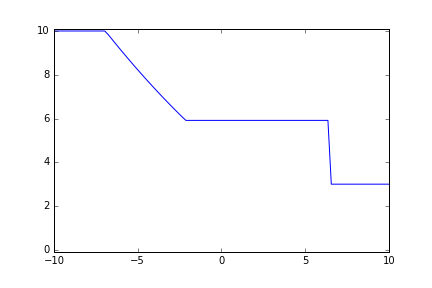
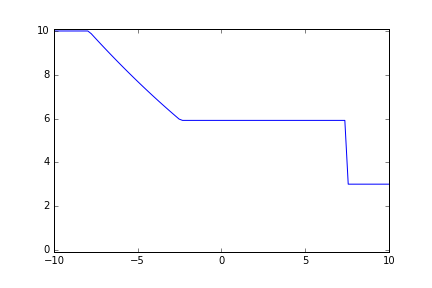
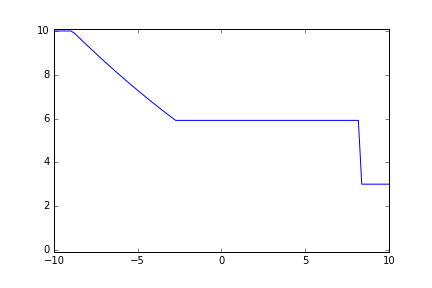
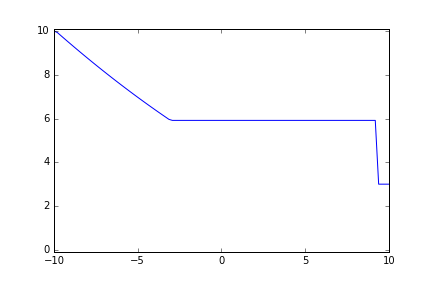
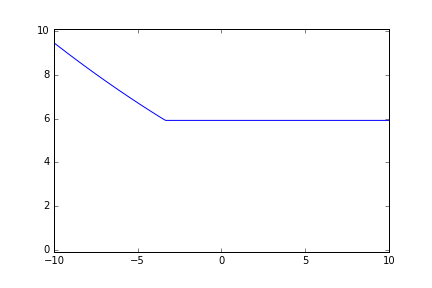
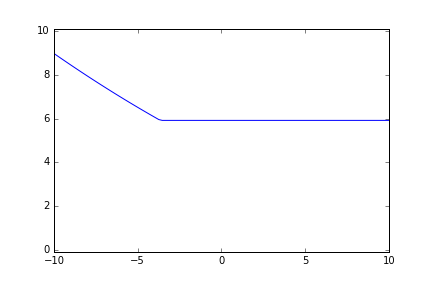
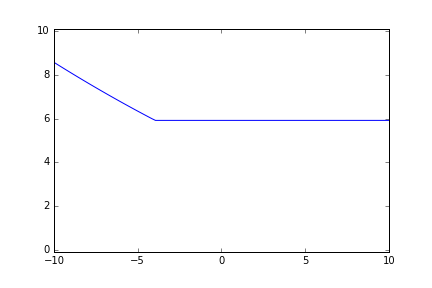
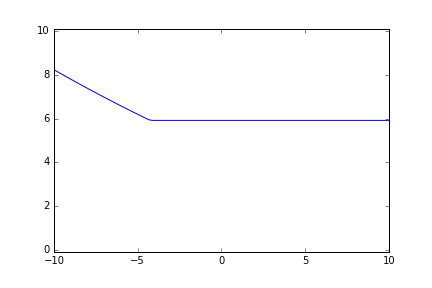
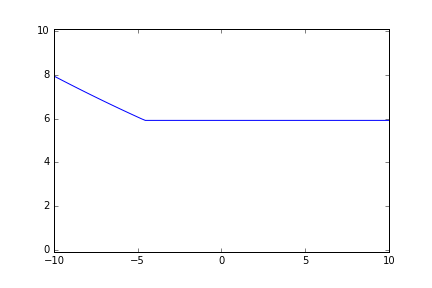
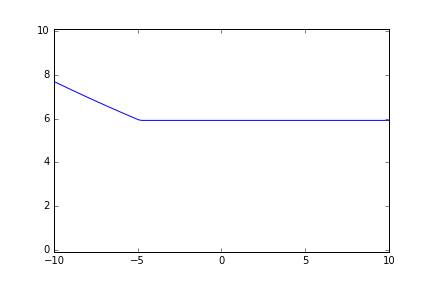
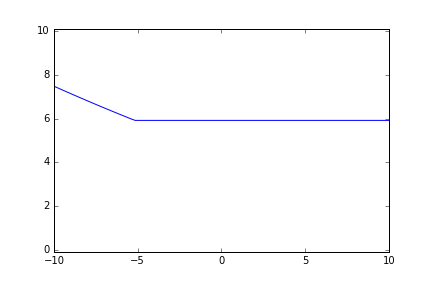
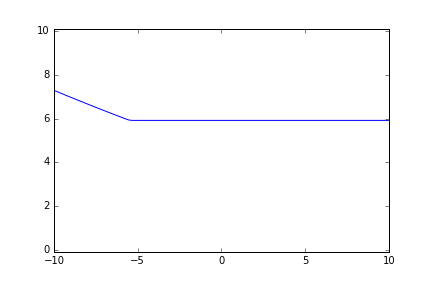
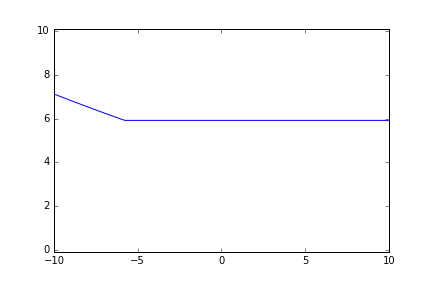

In [8]:
dambreak.plot_wet(10.,3.0)